# Performing a linecut in an arbitrary direction

When performing a linecut which is along an arbitrary direction (_i.e._, not along one of the principal H, K, or L axes), we must reorient part or all of the data using the `rotate_data()` function. This is because we perform the linecuts by binning pixels along the principal axes of the `np.array` which holds the scattering data, which typically correspond to the H, K, and L axes of reciprocal space. By rotating the data, we can bring the reciprocal space direction of interest to align with the principal axes of the array, simplifying the steps to obtain the resulting linecut.

<img src="https://github.com/stevenjgomez/nxs_analysis_tools/blob/main/docs/source/examples/img/rotate_data.png?raw=true" alt="Data rotation">

## Step 1: Rotate data

First, let's load the data. Here we use a simulated dataset output from the DISCUS software as an example.

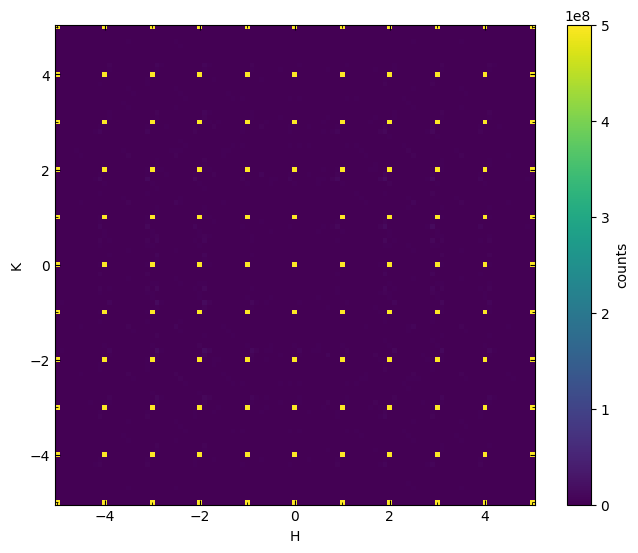

In [1]:
from nxs_analysis_tools.datareduction import load_discus_nxs, plot_slice
from nxs_analysis_tools.datasets import vacancies

# Load the dataset
data_dir = vacancies() # Download the example dataset into cache directory
data = load_discus_nxs(data_dir)
plot_slice(data[:,:,0.0], vmin=0, vmax=5e8)

Next,nxs_analysis_tools.datareduction to perform the rotation. We must provide several additional parameters that indicate the nature of the rotation. Because we are interested in performing a linecut along the 110 direction here, we seek to rotate about the 001 axis in reciprocal space by 45 degrees in order to bring the 110 reflection onto the x axis of the array. 

We must specify the angle between the two reciprocal lattice vectors that are perpendicular to the rotation axis: because the angle between the 100 and 010 axes is 90 degrees for this system, we specify `lattice_angle=90`.

Next, we specify the rotation angle as `rotation_angle=45`.

Lastly, we specify that we are rotating about the 001 vector (L direction) by setting `rotation_axis=2` (`0`=_H_, `1`=_K_).

Note: This can take a long time. If the linecut you are interested in depends only on a small range of reciprocal space that can be rotated, you may want to select a subset of your data for rotation. Here, because we are interested in a linecut along the 110 direction, it is sufficient to select data ranging from -1.0<L<1.0.

In [2]:
from nxs_analysis_tools.datareduction import rotate_data

# Rotate the dataset
rotated_data = rotate_data(data[:,:,-1.0:1.0], lattice_angle=90, rotation_angle=45, rotation_axis=2)


Rotation completed.


Let's visualize HK0 plane of the rotated dataset!

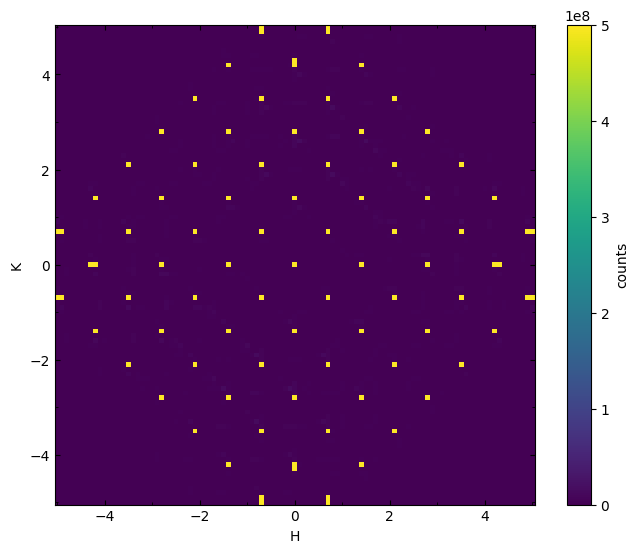

In [3]:
# Plot the data
plot_slice(rotated_data[:,:,0.0], vmin=0, vmax=5e8)

## Step 2: Scaling corrections

You may notice that the indices on the x axis and y axis of our plot are incorrect. See below that the reflections are now at unusual coordinates.

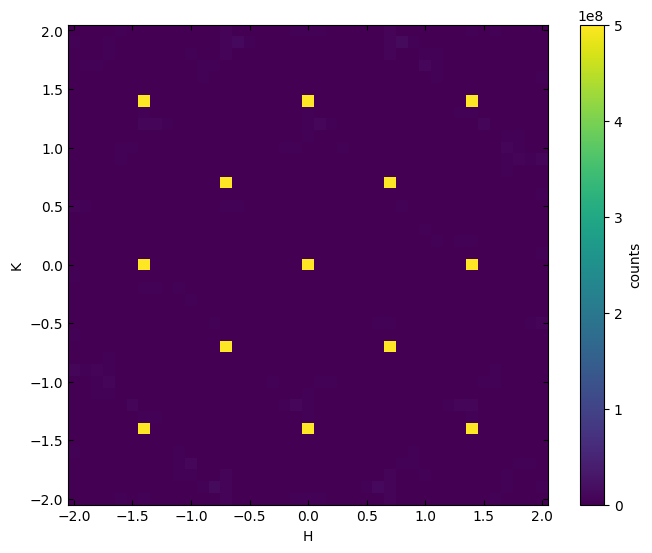

In [4]:
# Taking a closer look...
plot_slice(rotated_data[-2.0:2.0,-2.0:2.0,0.0], vmin=0, vmax=5e8)

We need to correct this to reflect that the x axis is now the 110 direction, and the y axis is now the -110 direction. This involves both a re-labeling and a scaling of the existing axes. We accomplish the latter by calculating the ratio between the lengths of the reciprocal space vectors 110 and 100.

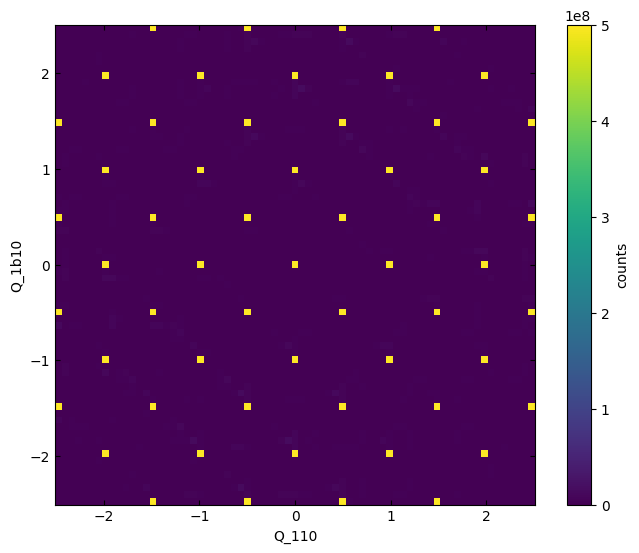

In [5]:
import numpy as np
from nexusformat.nexus import NXdata, NXfield

# Ratio between lengths of 110 and 100 vector
ratio = np.sqrt(1**2 + 1**2 + 0**2) / np.sqrt(1**2 + 0**2 + 0**2)

# Scale x and y axes, relabel all three for consistency
Q_110 = NXfield(rotated_data.H.nxdata/ratio, name='Q_110')
Q_1b10 = NXfield(rotated_data.K.nxdata/ratio, name='Q_1b10')
Q_001 = NXfield(rotated_data.L, name='Q_001')

# Create a new NXdata object with the scaled H and K axes
scaled_data = NXdata(rotated_data.counts, (Q_110, Q_1b10, Q_001))

plot_slice(scaled_data[-2.5:2.5,-2.5:2.5,0.0], vmin=0, vmax=5e8)

Now that we have the data correctly rotated and labeled, we can use `Scissors` to perform our linecut.

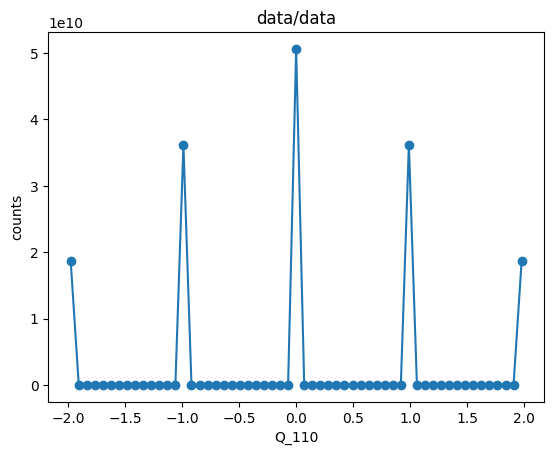

In [6]:
from nxs_analysis_tools.datareduction import Scissors

s = Scissors()
s.set_data(scaled_data)
s.cut_data(center=(0,0,0), window=(2,0.2,0.2))
s.linecut.plot(ls='-')